NN on vehicle

Fully connected


In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

import matplotlib.pyplot as plt
# plot param
%matplotlib inline
plt.rcParams['figure.figsize'] = (28.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.style.use('ggplot')

First, manipulate the input and output data

For now, always assumme that the state represent by single dimension vector
in other word it only has one feature.

Meanwhile the action size should be check if there is non-determinism in which action the controller should choose (it will influence how the score/loss function will be calculated). For instance, when the state has two ND actions (0 and 1), the loss function of that sample should be zero if the predicted action is action[0] OR action[1].

For this vehicle case the input size is one (there is no ND on the actions).

The uniqueness of the actions would determine the size of the output layer neuron's size

In [2]:
# parse the controller file
f = open('vehicle.txt', "r")

In [3]:
lines = f.readlines()

In [4]:
ltrain_dataset = []
ltrain_label = []

In [5]:
for x in lines:
    ltrain_dataset.append(x.split(' ')[0].strip('\n'))
    ltrain_label.append(x.split(' ')[1].strip('\n'))
f.close()

In [6]:
train_dataset = np.asarray(ltrain_dataset)
train_label = np.asarray(ltrain_label)

In [7]:
train_dataset = train_dataset.astype(np.float32)
train_label = train_label.astype(np.float32)

In [8]:
train_label.shape

(48018,)

In [9]:
train_dataset.shape

(48018,)

In [10]:
num_label = len(set(train_label))
num_label

18

In [11]:
lcoll_label = sorted(list(set(train_label)))

In [12]:
lcoll_label

[0.0,
 1.0,
 5.0,
 6.0,
 7.0,
 13.0,
 14.0,
 20.0,
 21.0,
 27.0,
 28.0,
 34.0,
 35.0,
 41.0,
 42.0,
 43.0,
 47.0,
 48.0]

In [13]:
lcoll_label.index(5)

2

In [14]:
train_dataset.shape

(48018,)

In [15]:
train_label.shape

(48018,)

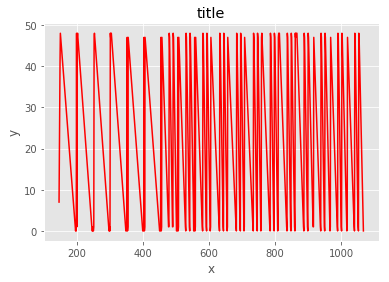

In [16]:
plt.plot(train_dataset[:200], train_label[:200], 'r')
plt.xlabel('x')
plt.ylabel('y')
plt.title('title')
plt.show()

In [17]:
lcoll_label.index(train_label[0])

4

In [18]:
range(train_label.shape[0])

range(0, 48018)

In [19]:
train_label_transformed = np.zeros_like(train_label)

In [20]:
for i in range(train_label.shape[0]):
    train_label_transformed[i] = lcoll_label.index(train_label[i])

In [21]:
train_label_transformed

array([ 4., 13., 17., ..., 15., 15.,  2.], dtype=float32)

In [22]:
train_dataset

array([  147.,   150.,   151., ..., 90665., 90666., 90667.], dtype=float32)

In [23]:
len(lcoll_label)

18

In [24]:
train_label_hot = (np.arange(len(lcoll_label)) == train_label_transformed[:, None]).astype(np.float32)

In [25]:
train_label_hot.shape

(48018, 18)

In [26]:
train_label_hot[0]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)

In [27]:
train_dataset_reform = train_dataset[:, None]

Logistic Regression

In [28]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
# train_subset = 10000

graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data into constants that are
  # attached to the graph.
  tf_train_dataset = tf.constant(train_dataset_reform)
  tf_train_labels = tf.constant(train_label_hot)
  
  # Variables.
  # These are the parameters that we are going to be training. The weight
  # matrix will be initialized using random values following a (truncated)
  # normal distribution. The biases get initialized to zero.
  weights = tf.Variable(tf.truncated_normal([1 , num_label]))
  biases = tf.Variable(tf.zeros([num_label]))
  
  # Training computation.
  # We multiply the inputs with the weight matrix, and add biases. We compute
  # the softmax and cross-entropy (it's one operation in TensorFlow, because
  # it's very common, and it can be optimized). We take the average of this
  # cross-entropy across all training examples: that's our loss.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(logits)
  # valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
  # test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [29]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [30]:
num_steps = 1000

with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the loss value and the training predictions returned as numpy
    # arrays.
    _, l, predictions = session.run([optimizer, loss, train_prediction])
    if (step % 100 == 0):
      print('Loss at step %d: %f' % (step, l))
      print('Training accuracy: %.1f%%' % accuracy(predictions, train_label_hot))
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      #print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
  #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Loss at step 0: 89001.804688
Training accuracy: 0.1%
Loss at step 100: 111318064.000000
Training accuracy: 7.5%
Loss at step 200: 90963432.000000
Training accuracy: 19.2%
Loss at step 300: 76106392.000000
Training accuracy: 3.7%
Loss at step 400: 86101768.000000
Training accuracy: 15.2%
Loss at step 500: 124001056.000000
Training accuracy: 15.5%
Loss at step 600: 118513064.000000
Training accuracy: 19.2%
Loss at step 700: 81590240.000000
Training accuracy: 7.9%
Loss at step 800: 77480928.000000
Training accuracy: 7.5%
Loss at step 900: 106734560.000000
Training accuracy: 13.2%


---
Next step
-------

Turn the logistic regression example with SGD into a n-hidden layer neural network with rectified linear units [nn.relu()](https://www.tensorflow.org/versions/r0.7/api_docs/python/nn.html#relu) and k hidden nodes. This model should improve your validation / test accuracy.

---

In [31]:
train_dataset_reform.shape

(48018, 1)

In [32]:
train_label_hot.shape

(48018, 18)

In [33]:
num_samples = train_label_hot.shape[0]

In [34]:
num_samples

48018

In [35]:
num_samples/num_label

2667.6666666666665

In [36]:
batch_size = int(num_samples)
hidden_size = 1024
hidden_size2 = 512
hidden_size3 = 18

# graph = tf.Graph()
# with graph.as_default():
# Input data. For the training data, we use a placeholder that will be fed
# at run time with a training minibatch.
tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, 1))
tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_label))

# Variables.
weights1 = tf.Variable(tf.truncated_normal([1, hidden_size]))
biases1 = tf.Variable(tf.zeros([hidden_size]))

weights2 = tf.Variable(tf.truncated_normal([hidden_size, hidden_size2]))
# biases2 = tf.Variable(tf.zeros([num_label]))
biases2 = tf.Variable(tf.zeros([hidden_size2]))

weights3 = tf.Variable(tf.truncated_normal([hidden_size2, hidden_size3]))
biases3 = tf.Variable(tf.zeros([hidden_size3]))

weights4 = tf.Variable(tf.truncated_normal([hidden_size3, num_label]))
biases4 = tf.Variable(tf.zeros([num_label]))

# Training computation.
logits1 = tf.matmul(tf_train_dataset, weights1) + biases1  
relu_act_func = tf.nn.relu(logits1)
logits2 = tf.matmul(relu_act_func, weights2) + biases2

relu_act_func2 = tf.nn.relu(logits2)
logits3 = tf.matmul(relu_act_func2, weights3) + biases3

relu_act_func3 = tf.nn.relu(logits3)
logits4 = tf.matmul(relu_act_func3, weights4) + biases4

# loss = tf.reduce_mean(tf.losses.absolute_difference(labels=tf_train_labels, predictions=train_prediction))
loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=logits4))

loss_summary = tf.summary.scalar('loss', loss)

# Optimizer.
#optimizer = tf.train.GradientDescentOptimizer(0.0001).minimize(loss)
optimizer = tf.train.AdamOptimizer(0.3).minimize(loss)

# Predictions for the training, validation, and test data.
train_prediction = tf.nn.softmax(logits4)
# writer = tf.summary.FileWriter('./vehicle', tf.get_default_graph())

In [37]:
batch_size

48018

In [38]:
iteration_one_epoch = np.floor(num_samples / batch_size)
iteration_one_epoch

1.0

In [39]:
# MINIBATCH GRADIENT DESCENT
loss_history = []
num_steps = int(iteration_one_epoch*50)

with tf.Session() as session:
#with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    #offset = (step * batch_size) % (train_label_hot.shape[0] - batch_size)
    # Generate a minibatch.
    #batch_data = train_dataset_reform[offset:(offset + batch_size), :]
    #batch_labels = train_label_hot[offset:(offset + batch_size), :]
    batch_data = train_dataset_reform
    batch_labels = train_label_hot
    
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions, added_summary = session.run(
        [optimizer, loss, train_prediction, loss_summary], feed_dict=feed_dict)
    
    # writer.add_summary(added_summary)
    loss_history.append(l)
    
    # if (step % iteration_one_epoch == 0):
    print("Minibatch loss at step %d: %f" % (step, l))
    print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
    # print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    # print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 39093880.000000
Minibatch accuracy: 2.7%
Minibatch loss at step 1: 366309216.000000
Minibatch accuracy: 0.1%
Minibatch loss at step 2: 841069248.000000
Minibatch accuracy: 3.7%
Minibatch loss at step 3: 556619712.000000
Minibatch accuracy: 15.5%
Minibatch loss at step 4: 297433504.000000
Minibatch accuracy: 15.2%
Minibatch loss at step 5: 369884000.000000
Minibatch accuracy: 3.1%
Minibatch loss at step 6: 210125392.000000
Minibatch accuracy: 1.3%
Minibatch loss at step 7: 56302388.000000
Minibatch accuracy: 13.2%
Minibatch loss at step 8: 3.215004
Minibatch accuracy: 19.2%
Minibatch loss at step 9: 980650.937500
Minibatch accuracy: 3.7%
Minibatch loss at step 10: 3.168487
Minibatch accuracy: 19.2%
Minibatch loss at step 11: 1012455.375000
Minibatch accuracy: 0.4%
Minibatch loss at step 12: 3.131607
Minibatch accuracy: 19.2%
Minibatch loss at step 13: 3.113926
Minibatch accuracy: 19.2%
Minibatch loss at step 14: 3.087184
Minibatch accuracy: 19.2%
Mi

In [46]:
np.sum(np.argmax(predictions,1) == 17)

48018

RNN

In [47]:
num_samples

48018

In [48]:
num_label

18

In [49]:
num_samples/53/2

453.0

In [50]:
num_epochs = 15
total_series_length = num_samples
truncated_backprop_length = 53
state_size = 1
num_classes = num_label
batch_size = 2
num_batches = total_series_length//batch_size//truncated_backprop_length

In [51]:
# computational graph input, output, initial state
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length, num_classes])
init_state = tf.placeholder(tf.float32, [batch_size, state_size])

In [52]:
# weights and biases
# input(k) + hidden state(k-1) to state(k)
W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32)
b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)
# hidden state to output
W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

In [53]:
# Unpack columns/slice each column (batch_size x truncated_backprop_length) -> (batch_sizex1) x tbl  
inputs_series = tf.unstack(batchX_placeholder, axis=1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

In [54]:
inputs_series

[<tf.Tensor 'unstack:0' shape=(2,) dtype=float32>,
 <tf.Tensor 'unstack:1' shape=(2,) dtype=float32>,
 <tf.Tensor 'unstack:2' shape=(2,) dtype=float32>,
 <tf.Tensor 'unstack:3' shape=(2,) dtype=float32>,
 <tf.Tensor 'unstack:4' shape=(2,) dtype=float32>,
 <tf.Tensor 'unstack:5' shape=(2,) dtype=float32>,
 <tf.Tensor 'unstack:6' shape=(2,) dtype=float32>,
 <tf.Tensor 'unstack:7' shape=(2,) dtype=float32>,
 <tf.Tensor 'unstack:8' shape=(2,) dtype=float32>,
 <tf.Tensor 'unstack:9' shape=(2,) dtype=float32>,
 <tf.Tensor 'unstack:10' shape=(2,) dtype=float32>,
 <tf.Tensor 'unstack:11' shape=(2,) dtype=float32>,
 <tf.Tensor 'unstack:12' shape=(2,) dtype=float32>,
 <tf.Tensor 'unstack:13' shape=(2,) dtype=float32>,
 <tf.Tensor 'unstack:14' shape=(2,) dtype=float32>,
 <tf.Tensor 'unstack:15' shape=(2,) dtype=float32>,
 <tf.Tensor 'unstack:16' shape=(2,) dtype=float32>,
 <tf.Tensor 'unstack:17' shape=(2,) dtype=float32>,
 <tf.Tensor 'unstack:18' shape=(2,) dtype=float32>,
 <tf.Tensor 'unstack:1

In [55]:
labels_series

[<tf.Tensor 'unstack_1:0' shape=(2, 18) dtype=float32>,
 <tf.Tensor 'unstack_1:1' shape=(2, 18) dtype=float32>,
 <tf.Tensor 'unstack_1:2' shape=(2, 18) dtype=float32>,
 <tf.Tensor 'unstack_1:3' shape=(2, 18) dtype=float32>,
 <tf.Tensor 'unstack_1:4' shape=(2, 18) dtype=float32>,
 <tf.Tensor 'unstack_1:5' shape=(2, 18) dtype=float32>,
 <tf.Tensor 'unstack_1:6' shape=(2, 18) dtype=float32>,
 <tf.Tensor 'unstack_1:7' shape=(2, 18) dtype=float32>,
 <tf.Tensor 'unstack_1:8' shape=(2, 18) dtype=float32>,
 <tf.Tensor 'unstack_1:9' shape=(2, 18) dtype=float32>,
 <tf.Tensor 'unstack_1:10' shape=(2, 18) dtype=float32>,
 <tf.Tensor 'unstack_1:11' shape=(2, 18) dtype=float32>,
 <tf.Tensor 'unstack_1:12' shape=(2, 18) dtype=float32>,
 <tf.Tensor 'unstack_1:13' shape=(2, 18) dtype=float32>,
 <tf.Tensor 'unstack_1:14' shape=(2, 18) dtype=float32>,
 <tf.Tensor 'unstack_1:15' shape=(2, 18) dtype=float32>,
 <tf.Tensor 'unstack_1:16' shape=(2, 18) dtype=float32>,
 <tf.Tensor 'unstack_1:17' shape=(2, 18) 

In [56]:
# Forward pass
current_state = init_state # batch_s x state_s
states_series = []
for current_input in inputs_series:
    # bsxss
    current_input = tf.reshape(current_input, [batch_size, 1]) 
    # bsxis concat bsxss -> bsx(is+ss) 
    input_and_state_concatenated = tf.concat([current_input, current_state],1)  # Increasing number of columns
    # 5x5, 5x4 -> 5x4 + 1x4 = 5x4
    # next_state = tf.tanh(tf.matmul(input_and_state_concatenated, W) + b)  # Broadcasted addition
    next_state = tf.nn.relu(tf.matmul(input_and_state_concatenated, W) + b)  # Broadcasted addition
    
    states_series.append(next_state)
    current_state = next_state

In [57]:
# loss calculation
# 5x4 * 4x2 + 1x2 = 5x2
logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition

# the same size with the batch for the training
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]
# predictions_series = [tf.round(tf.sigmoid(logits)) for logits in logits_series]

# compute the loss with cross entropy (it will be probabilistic 0-1 compare it with label)
losses = [tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits,labels = labels) for logits, labels in zip(logits_series,labels_series)]
# losses = [tf.nn.sigmoid_cross_entropy_with_logits(logits = logits,labels = labels) for logits, labels in zip(logits_series,labels_series)]

# make the loss scalar
total_loss = tf.reduce_mean(losses)
# gradient step
train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

In [58]:
train_label_hot.shape

(48018, 18)

In [59]:
train_dataset_reform.shape

(48018, 1)

In [60]:
x = train_dataset_reform.reshape((batch_size,-1))
y = train_label_hot.reshape((batch_size, -1, num_classes))

In [61]:
x.shape

(2, 24009)

In [62]:
y.shape

(2, 24009, 18)

In [63]:
num_epochs = 50

In [64]:
num_batches

453

In [65]:
def accuracy_list(predictions, labels):
  return (100*np.mean(np.argmax(np.asarray(predictions),2) == np.argmax(np.asarray(labels),2)))

In [66]:
with tf.Session() as sess:
    # sess.run(tf.initialize_all_variables())
    sess.run(tf.global_variables_initializer())
    # plt.ion()
    # plt.figure()
    # plt.show()
    loss_list = []
    
    for epoch_idx in range(num_epochs): # 100
        _current_state = np.zeros((batch_size, state_size))

        print("New data, epoch", epoch_idx)

        for batch_idx in range(num_batches): # 666
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length
            # all 5 rows, certain numbers of column which the total = 15 columns
            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]
            
            # calculate loss, gradient step, 
            _total_loss, _train_step, _current_state, _predictions_series, _labels_series = sess.run(
                [total_loss, train_step, current_state, predictions_series, labels_series],
                feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    # it was part of computational graph, where the init_state is the placeholder
                    init_state:_current_state
                })

            loss_list.append(_total_loss)
            # print("prediction", _predictions_series)
            # print("label",_labels_series)
           
            if (batch_idx%(num_batches//10) == 0):
                print("Step",batch_idx, "Loss", _total_loss)
                # plot(loss_list, _predictions_series, batchX, batchY)

    # accuracy
    _current_state = np.zeros((batch_size, state_size))
    acc = 0
    total_acc = 0
    for batch_idx in range(num_batches):
        start_idx = batch_idx * truncated_backprop_length
        end_idx = start_idx + truncated_backprop_length
        
        batchX = x[:,start_idx:end_idx]
        batchY = y[:,start_idx:end_idx]

        # calculate loss, gradient step, 
        _predictions_series, _labels_series = sess.run([predictions_series, labels_series],
            feed_dict={
                batchX_placeholder:batchX,
                batchY_placeholder:batchY,
                # it was part of computational graph, where the init_state is the placeholder
                init_state:_current_state
            })
        acc = accuracy_list( _predictions_series, _labels_series)
        print("batch:",batch_idx,", accuracy:",acc)
        total_acc += acc
    
    print(total_acc/num_batches)
# plt.ioff()
# plt.show()


New data, epoch 0
Step 0 Loss 8501.739
Step 45 Loss 2.082132
Step 90 Loss 2.2911139
Step 135 Loss 2.2355294
Step 180 Loss 2.3489084
Step 225 Loss 2.357231
Step 270 Loss 2.1763716
Step 315 Loss 2.675916
Step 360 Loss 1.9061393
Step 405 Loss 2.6521223
Step 450 Loss 2.3639457
New data, epoch 1
Step 0 Loss 2.8934162
Step 45 Loss 1.9621732
Step 90 Loss 2.2378416
Step 135 Loss 2.3646743
Step 180 Loss 2.3391216
Step 225 Loss 2.3797293
Step 270 Loss 2.2004259
Step 315 Loss 2.7466142
Step 360 Loss 1.9508241
Step 405 Loss 2.5503995
Step 450 Loss 2.4210515
New data, epoch 2
Step 0 Loss 2.860684
Step 45 Loss 1.996052
Step 90 Loss 2.2158673
Step 135 Loss 2.3783388
Step 180 Loss 2.324613
Step 225 Loss 2.3834722
Step 270 Loss 2.220913
Step 315 Loss 2.771669
Step 360 Loss 1.976799
Step 405 Loss 2.4933639
Step 450 Loss 2.452447
New data, epoch 3
Step 0 Loss 2.8341274
Step 45 Loss 2.0200763
Step 90 Loss 2.2112582
Step 135 Loss 2.3829849
Step 180 Loss 2.3111286
Step 225 Loss 2.3837755
Step 270 Loss 2.234

Step 360 Loss 2.071888
Step 405 Loss 2.334043
Step 450 Loss 2.536887
New data, epoch 30
Step 0 Loss 2.6825404
Step 45 Loss 2.0945768
Step 90 Loss 2.243743
Step 135 Loss 2.3997788
Step 180 Loss 2.2376943
Step 225 Loss 2.3728223
Step 270 Loss 2.2801197
Step 315 Loss 2.8173468
Step 360 Loss 2.072518
Step 405 Loss 2.3330956
Step 450 Loss 2.537463
New data, epoch 31
Step 0 Loss 2.6811275
Step 45 Loss 2.094996
Step 90 Loss 2.244204
Step 135 Loss 2.3998384
Step 180 Loss 2.2370858
Step 225 Loss 2.372671
Step 270 Loss 2.2803853
Step 315 Loss 2.8174808
Step 360 Loss 2.073115
Step 405 Loss 2.3321962
Step 450 Loss 2.538011
New data, epoch 32
Step 0 Loss 2.6797807
Step 45 Loss 2.0953932
Step 90 Loss 2.244645
Step 135 Loss 2.3998919
Step 180 Loss 2.2365074
Step 225 Loss 2.372526
Step 270 Loss 2.280636
Step 315 Loss 2.8176067
Step 360 Loss 2.0736814
Step 405 Loss 2.33134
Step 450 Loss 2.5385342
New data, epoch 33
Step 0 Loss 2.678495
Step 45 Loss 2.0957701
Step 90 Loss 2.2450671
Step 135 Loss 2.39993

batch: 109 , accuracy: 7.547169811320755
batch: 110 , accuracy: 8.49056603773585
batch: 111 , accuracy: 12.264150943396226
batch: 112 , accuracy: 10.377358490566039
batch: 113 , accuracy: 9.433962264150944
batch: 114 , accuracy: 15.09433962264151
batch: 115 , accuracy: 16.9811320754717
batch: 116 , accuracy: 16.037735849056602
batch: 117 , accuracy: 15.09433962264151
batch: 118 , accuracy: 26.41509433962264
batch: 119 , accuracy: 16.037735849056602
batch: 120 , accuracy: 11.320754716981133
batch: 121 , accuracy: 10.377358490566039
batch: 122 , accuracy: 13.20754716981132
batch: 123 , accuracy: 20.754716981132077
batch: 124 , accuracy: 20.754716981132077
batch: 125 , accuracy: 16.037735849056602
batch: 126 , accuracy: 0.0
batch: 127 , accuracy: 2.8301886792452833
batch: 128 , accuracy: 8.49056603773585
batch: 129 , accuracy: 9.433962264150944
batch: 130 , accuracy: 9.433962264150944
batch: 131 , accuracy: 13.20754716981132
batch: 132 , accuracy: 5.660377358490567
batch: 133 , accuracy: 

batch: 323 , accuracy: 4.716981132075472
batch: 324 , accuracy: 5.660377358490567
batch: 325 , accuracy: 12.264150943396226
batch: 326 , accuracy: 45.28301886792453
batch: 327 , accuracy: 38.67924528301887
batch: 328 , accuracy: 17.92452830188679
batch: 329 , accuracy: 26.41509433962264
batch: 330 , accuracy: 22.641509433962266
batch: 331 , accuracy: 16.9811320754717
batch: 332 , accuracy: 8.49056603773585
batch: 333 , accuracy: 8.49056603773585
batch: 334 , accuracy: 2.8301886792452833
batch: 335 , accuracy: 0.0
batch: 336 , accuracy: 1.8867924528301887
batch: 337 , accuracy: 1.8867924528301887
batch: 338 , accuracy: 0.9433962264150944
batch: 339 , accuracy: 4.716981132075472
batch: 340 , accuracy: 13.20754716981132
batch: 341 , accuracy: 18.867924528301888
batch: 342 , accuracy: 16.9811320754717
batch: 343 , accuracy: 15.09433962264151
batch: 344 , accuracy: 8.49056603773585
batch: 345 , accuracy: 16.9811320754717
batch: 346 , accuracy: 33.0188679245283
batch: 347 , accuracy: 52.8301

In [92]:
_predictions_series[0]

array([[0.13241306, 0.02757386, 0.04472994, 0.15169942, 0.01510084,
        0.08247881, 0.00120155, 0.02419116, 0.00051674, 0.00379654,
        0.01344477, 0.07153476, 0.00606989, 0.01386202, 0.18017827,
        0.03059891, 0.03409372, 0.16651577],
       [0.13241306, 0.02757386, 0.04472994, 0.15169942, 0.01510084,
        0.08247881, 0.00120155, 0.02419116, 0.00051674, 0.00379654,
        0.01344477, 0.07153476, 0.00606989, 0.01386202, 0.18017827,
        0.03059891, 0.03409372, 0.16651577]], dtype=float32)

In [93]:
_labels_series[0]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0.]], dtype=float32)

In [94]:
np.argmax(_predictions_series[1], 1)

array([14, 14], dtype=int64)

In [95]:
np.argmax(_labels_series[1], 1)

array([0, 2], dtype=int64)

In [96]:
np.asarray(_predictions_series).shape

(53, 2, 18)

In [97]:
np.argmax(np.asarray(_labels_series),2).shape

(53, 2)

In [98]:
np.argmax(np.asarray(_predictions_series),2).shape

(53, 2)

In [99]:
np.argmax(np.asarray(_labels_series),2)

array([[ 0, 15],
       [ 0,  2],
       [16, 14],
       [16, 14],
       [ 0, 15],
       [ 0,  2],
       [16, 14],
       [16, 14],
       [ 0, 15],
       [ 0,  2],
       [ 2, 14],
       [ 2, 14],
       [14, 14],
       [14, 15],
       [16,  2],
       [16, 14],
       [ 0, 14],
       [ 0, 15],
       [ 2,  2],
       [ 2, 14],
       [14, 14],
       [14, 15],
       [16,  2],
       [16, 14],
       [ 0, 14],
       [ 0, 15],
       [ 2, 15],
       [ 2,  2],
       [14, 15],
       [16, 15],
       [16, 15],
       [ 0,  2],
       [ 0, 14],
       [ 0, 14],
       [16, 15],
       [16,  2],
       [ 0, 14],
       [ 0, 15],
       [16, 15],
       [16,  2],
       [ 0,  3],
       [ 0, 14],
       [ 2, 14],
       [ 2, 15],
       [14,  2],
       [14, 15],
       [16, 15],
       [16,  2],
       [ 0,  3],
       [ 0, 15],
       [ 2, 15],
       [ 2, 15],
       [14,  2]], dtype=int64)

In [101]:
np.argmax(np.asarray(_predictions_series),2)

array([[14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14],
       [14, 14]], dtype=int64)

In [139]:
100*np.mean(np.argmax(np.asarray(_predictions_series),2) == np.argmax(np.asarray(_labels_series),2))

24.528301886792452